In [3]:
import wikipedia
import pandas as pd
from transformers import AutoTokenizer, TFAutoModelForMaskedLM
import tensorflow as tf
from datasets import Dataset
import datasets
from sklearn.cluster import DBSCAN
import numpy as np
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.express as px
from kneed import KneeLocator
from sklearn.metrics import silhouette_score

from sklearn.neighbors import NearestNeighbors
from pypdf import PdfReader
import os
import tensorflow as tf

In [2]:

directory_path = '/Users/ammar/Developer/loose/testembedclustering/documents/'
document = ""

for filename in os.listdir(directory_path):
    file_path = os.path.join(directory_path, filename)
    if os.path.isfile(file_path):
        reader = PdfReader(directory_path + filename) 
        for i in range(len(reader.pages)):
            page = reader.pages[i].extract_text()
            page = page.replace("\n", " ")
            document += page


In [3]:
document += wikipedia.page("History of the United States").content

In [4]:
document += wikipedia.page("History of Europe").content

In [5]:
document += wikipedia.page("History of China").content

In [6]:
document += wikipedia.page("Elvis Presley").content

In [7]:
document += wikipedia.page("History of Poland").content

In [8]:
document += wikipedia.page("Manhattan Project").content

In [9]:
len(document)

813859

In [10]:
chunks = document.split('.')
print(len(chunks))



8115


In [11]:
df = pd.DataFrame(chunks, columns=['Chunks'])

In [12]:
display(df)

,Chunks
0,Mustafa 1 Muhammad Mustafa Br
1,Ali Saadaldin Islamic Education 8 May 2023 Ca...
2,The common description that permeates through...
3,” Though “Sharia” is an expansive term that in...
4,In order to fully understand and comprehend t...
...,...
8110,doi:10
8111,1080/00295450
8112,2021
8113,1901002


In [13]:
dataset = Dataset.from_pandas(df)


In [14]:
dataset

Dataset({
    features: ['Chunks'],
    num_rows: 8115
})

In [15]:
if tf.config.list_physical_devices('GPU'):
    print("Using GPU via Metal")
else:
    print("Using CPU")


Using CPU


In [16]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
model = TFAutoModelForMaskedLM.from_pretrained("google-bert/bert-base-uncased")

All PyTorch model weights were used when initializing TFBertForMaskedLM.

All the weights of TFBertForMaskedLM were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


In [17]:
def embed(texts):
    inputs = tokenizer(texts, return_tensors='tf', padding=True, truncation=True)
    outputs = model(inputs, output_hidden_states=True)
    embeddings = outputs.hidden_states[-1]

    return embeddings

def embed_batch(batch):
    embeddings = embed(batch["Chunks"])
    batch_size = tf.shape(embeddings)[0]
    return {"embed": [embeddings[i] for i in range(batch_size)]}



In [21]:
embedded_dataset = dataset.map(embed_batch, batched=True, batch_size=16)  # Adjust batch_size as needed

Map:   0%|          | 0/8115 [00:00<?, ? examples/s]

In [19]:
def embed2(text):
    inputs = tokenizer(text, return_tensors='tf')
    outputs = model(inputs, output_hidden_states=True)
    tokens = inputs["input_ids"][0]
    embeddings = outputs.hidden_states[-1][0]
    print(tokens.shape, embeddings.shape)
    return {'embed':embeddings}



In [20]:
embedded_dataset2 = dataset.map(lambda examples: embed2(examples["Chunks"]))

Map:   0%|          | 0/8115 [00:00<?, ? examples/s]

(7,) (7, 768)
(48,) (48, 768)
(22,) (22, 768)
(36,) (36, 768)
(49,) (49, 768)
(18,) (18, 768)
(18,) (18, 768)
(30,) (30, 768)
(70,) (70, 768)
(52,) (52, 768)
(9,) (9, 768)
(26,) (26, 768)
(32,) (32, 768)
(32,) (32, 768)
(52,) (52, 768)
(34,) (34, 768)
(29,) (29, 768)
(27,) (27, 768)
(50,) (50, 768)
(27,) (27, 768)
(39,) (39, 768)
(33,) (33, 768)
(15,) (15, 768)
(24,) (24, 768)
(30,) (30, 768)
(37,) (37, 768)
(43,) (43, 768)
(38,) (38, 768)
(9,) (9, 768)
(64,) (64, 768)
(17,) (17, 768)
(53,) (53, 768)
(17,) (17, 768)
(49,) (49, 768)
(24,) (24, 768)
(30,) (30, 768)
(29,) (29, 768)
(34,) (34, 768)
(13,) (13, 768)
(19,) (19, 768)
(55,) (55, 768)
(26,) (26, 768)
(12,) (12, 768)
(26,) (26, 768)
(27,) (27, 768)
(20,) (20, 768)
(33,) (33, 768)
(23,) (23, 768)
(35,) (35, 768)
(28,) (28, 768)
(12,) (12, 768)
(71,) (71, 768)
(48,) (48, 768)
(34,) (34, 768)
(31,) (31, 768)
(42,) (42, 768)
(30,) (30, 768)
(11,) (11, 768)
(10,) (10, 768)
(44,) (44, 768)
(89,) (89, 768)
(36,) (36, 768)
(81,) (81, 768

KeyboardInterrupt: 

In [22]:
def average_embeddings(examples):
    examples['averaged_embeddings'] = [np.mean(embedding, axis=0) for embedding in examples['embed']]
    return examples

embedded_dataset = embedded_dataset.map(average_embeddings, batched=True)


Map:   0%|          | 0/8115 [00:00<?, ? examples/s]

In [23]:
embedded_dataset.save_to_disk("embedded_dataset")

Saving the dataset (0/3 shards):   0%|          | 0/8115 [00:00<?, ? examples/s]

In [4]:
embedded_dataset = datasets.load_from_disk("embedded_dataset")

In [5]:
embedded_dataset

Dataset({
    features: ['Chunks', 'embed', 'averaged_embeddings'],
    num_rows: 8115
})

In [7]:
averaged_embeddings = np.array(embedded_dataset['averaged_embeddings'])


In [18]:
averaged_embeddings.shape

(8115, 768)

In [9]:
tsne = TSNE(n_components=2)
reduced_embeddings = tsne.fit_transform(averaged_embeddings)


In [10]:
reduced_embeddings.shape

(8115, 2)

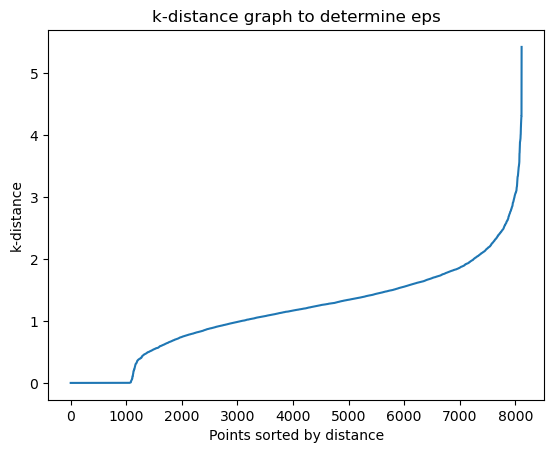

Optimal eps value: 3.895318600503448


In [42]:
k = 4
neigh = NearestNeighbors(n_neighbors=k)
nbrs = neigh.fit(reduced_embeddings)
distances, indices = nbrs.kneighbors(reduced_embeddings)

distances = np.sort(distances[:, k-1], axis=0)
plt.plot(distances)
plt.xlabel('Points sorted by distance')
plt.ylabel('k-distance')
plt.title('k-distance graph to determine eps')
plt.show()

kneedle = KneeLocator(range(len(distances)), distances, S=1.0, curve='convex', direction='increasing')
optimal_eps = distances[kneedle.elbow]

print(f'Optimal eps value: {optimal_eps}')

In [43]:
db = DBSCAN(eps=2.25, min_samples=4).fit(reduced_embeddings)
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)



Estimated number of clusters: 129
Estimated number of noise points: 311


## 2d

In [44]:
clustered_dataset = embedded_dataset.add_column('cluster', labels)
clustered_dataset

scale_factor = 1

scaled_embeddings = reduced_embeddings * scale_factor

tsne_df = pd.DataFrame(scaled_embeddings, columns=['Component 1', 'Component 2'])
tsne_df['text'] = clustered_dataset['Chunks']
tsne_df['cluster'] = clustered_dataset['cluster']


fig = px.scatter(
    tsne_df,
    x='Component 1',
    y='Component 2',
    color='cluster',
    hover_data=['text'],
    #color_continuous_scale=px.colors.diverging.BrBG
)

fig.update_traces(marker=dict(size=3.5))  # Adjust size as needed


fig.update_layout(
    scene=dict(
        xaxis=dict(nticks=10, range=[tsne_df['Component 1'].min()-10, tsne_df['Component 1'].max()+10]),
        yaxis=dict(nticks=10, range=[tsne_df['Component 2'].min()-10, tsne_df['Component 2'].max()+10]),
        aspectratio=dict(x=1.5, y=1.5)
    )
)

fig.show()

## 3d


In [24]:
clustered_dataset = embedded_dataset.add_column('cluster', labels)
clustered_dataset

scale_factor = 1

scaled_embeddings = reduced_embeddings * scale_factor

tsne_df = pd.DataFrame(scaled_embeddings, columns=['Component 1', 'Component 2', 'Component 3'])
tsne_df['text'] = clustered_dataset['Chunks']
tsne_df['cluster'] = clustered_dataset['cluster']


fig = px.scatter_3d(
    tsne_df,
    x='Component 1',
    y='Component 2',
    z='Component 3',
    color='cluster',
    hover_data=['text'],
    #color_continuous_scale=px.colors.diverging.BrBG
)

fig.update_traces(marker=dict(size=3.5))  # Adjust size as needed


fig.update_layout(
    scene=dict(
        xaxis=dict(nticks=10, range=[tsne_df['Component 1'].min()-10, tsne_df['Component 1'].max()+10]),
        yaxis=dict(nticks=10, range=[tsne_df['Component 2'].min()-10, tsne_df['Component 2'].max()+10]),
        zaxis=dict(nticks=10, range=[tsne_df['Component 3'].min()-10, tsne_df['Component 3'].max()+10]),
        aspectratio=dict(x=1.5, y=1.5, z=1.5)
    )
)

fig.show()

In [45]:
fig.write_html("interactive_plot3.html")
